In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import pandas as pd
import numpy as np
from rank_bm25 import BM25Okapi
from model_helper import l2_get_evaluation_set_175, l2_get_evaluation_set_6, l2_QUERY, l2_DOCUMENT, two_gram_overlap, l2_get_evaluation_set
import nltk
import heapq
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import torch
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from model_helper import l2_QUERY, l2_DOCUMENT, l2_get_evaluation_set
import colbert
from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection

df = l2_get_evaluation_set_175()
total_rows = df.shape[0]
print(df.shape)
df.head()

(1067, 5)


,depth_2_summary,book_text,model_size,book_num,document_index
10797,"Johnnie Consadine, a determined and ambitious ...","THE BIRTH OF A WOMAN-CHILD\n\n""Whose cradle's ...",175b,0,0
10798,Johnnie and Shade walk through the town of Cot...,"sunbonnet, and cowhide shoes with the apparel ...",175b,0,1
10799,Johnnie is used to hardship and is excited to ...,"was on night turn, and it had not been remade....",175b,0,2
10800,Stoddard is a socialist who believes that marr...,"shine to you it'll be money in your pocket.""\n...",175b,0,3
10801,Mandy invites Johnnie to a party at the Uplift...,It was all over in a moment. The loom-fixers h...,175b,0,4


In [32]:
tokenized_corpus = [doc.split(" ") for doc in df[l2_DOCUMENT]]
bm25 = BM25Okapi(tokenized_corpus)

print("Starting recall@k calculation for k=1 to 10...")

# Initialize counters for each k
n_correct_at_k = {k: 0 for k in range(1, 11)}
total_rows = len(df)

# Initialize tqdm progress bar
pbar = tqdm.tqdm(total=total_rows, desc='Recall@k', unit='row')

for index, row in enumerate(df.itertuples()):
    tokenized_query = getattr(row, l2_QUERY).split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    
    for k in range(1, 11):
        top_k_indexes = heapq.nlargest(k, range(len(doc_scores)), key=lambda i: doc_scores[i])
        if index in top_k_indexes:
            n_correct_at_k[k] += 1
    
    # Update progress bar
    pbar.update(1)

# Close the progress bar upon completion
pbar.close()

# Calculate and print recall at each k
recall_at_k_bm25 = {k: n_correct_at_k[k] / total_rows for k in range(1, 11)}
for k in range(1, 11):
    print(f"Recall at k = {k}: {recall_at_k_bm25[k]:.4f}")

print("Calculation completed.")


Starting recall@k calculation for k=1 to 10...


Recall@k: 100%|██████████| 1067/1067 [00:19<00:00, 54.78row/s]

Recall at k = 1: 0.5192
Recall at k = 2: 0.5567
Recall at k = 3: 0.5717
Recall at k = 4: 0.5801
Recall at k = 5: 0.5839
Recall at k = 6: 0.5876
Recall at k = 7: 0.5942
Recall at k = 8: 0.5998
Recall at k = 9: 0.6045
Recall at k = 10: 0.6064
Calculation completed.


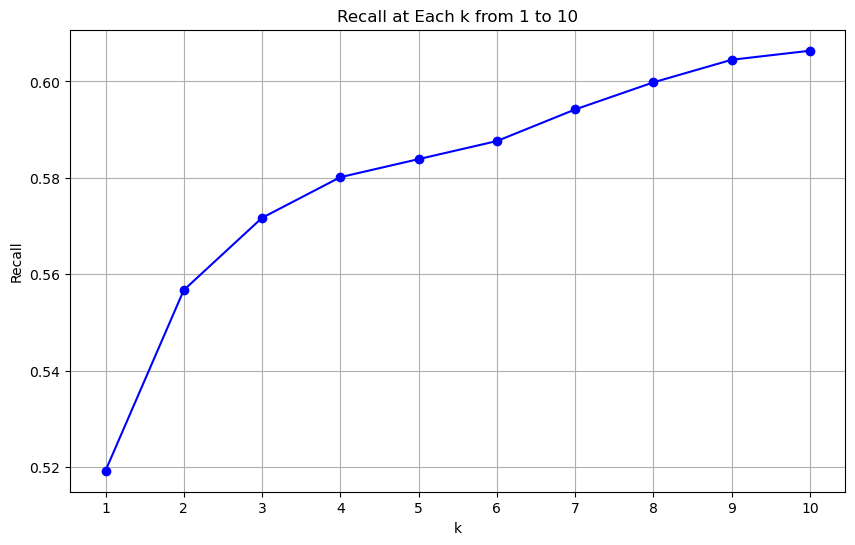

In [33]:
# Data for plotting
ks = list(recall_at_k_bm25.keys())
recalls = list(recall_at_k_bm25.values())

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(ks, recalls, marker='o', linestyle='-', color='b')
plt.title('Recall at Each k from 1 to 10')
plt.xlabel('k')
plt.ylabel('Recall')
plt.xticks(np.arange(1, 11, step=1))
plt.grid(True)

# Display the plot
plt.show()

In [8]:
checkpoint = 'colbert-ir/colbertv2.0'
nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 300 # truncate passages at 300 tokens
max_id = 4000

index_name = f'{nbits}bits'
collection = df[l2_DOCUMENT].to_list()
queries = df[l2_QUERY].to_list()

In [9]:
checkpoint = 'colbert-ir/colbertv2.0'

with Run().context(RunConfig(nranks=1, experiment='notebook')):  # nranks specifies the number of GPUs to use
    config = ColBERTConfig(doc_maxlen=doc_maxlen, nbits=nbits, kmeans_niters=4) # kmeans_niters specifies the number of iterations of k-means clustering; 4 is a good and fast default.
                                                                                # Consider larger numbers for small datasets.

    indexer = Indexer(checkpoint=checkpoint, config=config)
    indexer.index(name=index_name, collection=collection[:max_id], overwrite=True)



[Apr 11, 22:21:58] #> Note: Output directory /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits already exists


[Apr 11, 22:21:58] #> Will delete 10 files already at /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits in 20 seconds...
#> Starting...
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "load_index_with_mmap": false,
    "index_path": null,
    "index_bsize": 64,
    "nbits": 2,
    "kmeans_niters": 4,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_negatives": true,
    "reranker": false,
    "distillation_alpha": 1.0,
    "ignore_scores": false,
    "model_name": null,
    "quer

/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Apr 11, 22:22:20] [0] 		 # of sampled PIDs = 1067 	 sampled_pids[:3] = [853, 20, 611]
[Apr 11, 22:22:20] [0] 		 #> Encoding 1067 passages..


  0%|          | 0/17 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  6%|▌         | 1/17 [00:05<01:20,  5.02s/it]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 17/17 [01:16<00:00,  4.47s/it]


[Apr 11, 22:23:37] [0] 		 avg_doclen_est = 245.4639129638672 	 len(local_sample) = 1,067
[Apr 11, 22:23:37] [0] 		 Creating 4,096 partitions.
[Apr 11, 22:23:37] [0] 		 *Estimated* 261,909 embeddings.
[Apr 11, 22:23:37] [0] 		 #> Saving the indexing plan to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/plan.json ..
Clustering 248815 points in 128D to 4096 clusters, redo 1 times, 4 iterations
  Preprocessing in 0.01 s
  Iteration 3 (2.84 s, search 2.81 s): objective=69384 imbalance=1.390 nsplit=0         
[0.039, 0.039, 0.041, 0.036, 0.038, 0.036, 0.035, 0.037, 0.037, 0.04, 0.036, 0.039, 0.037, 0.039, 0.038, 0.04, 0.034, 0.038, 0.037, 0.036, 0.037, 0.039, 0.037, 0.038, 0.037, 0.035, 0.037, 0.037, 0.039, 0.039, 0.037, 0.04, 0.041, 0.037, 0.037, 0.036, 0.035, 0.037, 0.038, 0.044, 0.041, 0.037, 0.037, 0.036, 0.039, 0.036, 0.036, 0.041, 0.041, 0.035, 0.037, 0.038, 0.037, 0.038, 0.037, 0.038, 0.041, 0.039, 0.044, 0.036, 0.036, 0.04, 0.038, 0.039, 0.039, 0.04, 0.

0it [00:00, ?it/s]
100%|██████████| 17/17 [01:16<00:00,  4.50s/it]


[Apr 11, 22:24:59] [0] 		 #> Saving chunk 0: 	 1,067 passages and 261,910 embeddings. From #0 onward.


1it [01:20, 80.13s/it]
100%|██████████| 4096/4096 [00:00<00:00, 139586.35it/s]


[Apr 11, 22:25:00] [0] 		 #> Checking all files were saved...
[Apr 11, 22:25:00] [0] 		 Found all files!
[Apr 11, 22:25:00] [0] 		 #> Building IVF...
[Apr 11, 22:25:00] [0] 		 #> Loading codes...
[Apr 11, 22:25:00] [0] 		 Sorting codes...
[Apr 11, 22:25:01] [0] 		 Getting unique codes...
[Apr 11, 22:25:01] #> Optimizing IVF to store map from centroids to list of pids..
[Apr 11, 22:25:01] #> Building the emb2pid mapping..
[Apr 11, 22:25:01] len(emb2pid) = 261910
[Apr 11, 22:25:01] #> Saved optimized IVF to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/ivf.pid.pt
[Apr 11, 22:25:01] [0] 		 #> Saving the indexing metadata to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/metadata.json ..
#> Joined...


In [12]:
with Run().context(RunConfig(experiment='notebook')):
    searcher = Searcher(index=index_name, collection=collection)

[Apr 11, 22:25:24] #> Loading codec...
[Apr 11, 22:25:24] #> Loading IVF...
[Apr 11, 22:25:24] #> Loading doclens...


/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]

[Apr 11, 22:25:24] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 375.09it/s]


Calculating recall scores:   0%|          | 0/1067 [00:00<?, ?it/s]

/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Calculating recall scores: 100%|██████████| 1067/1067 [00:45<00:00, 23.58it/s]

Average Recall @k: {1: 0.7291471415182755, 2: 0.795688847235239, 3: 0.8322399250234301, 4: 0.8509840674789129, 5: 0.8537956888472352, 6: 0.865979381443299, 7: 0.8772258669165885, 8: 0.8828491096532334, 9: 0.8884723523898782, 10: 0.8922211808809747}


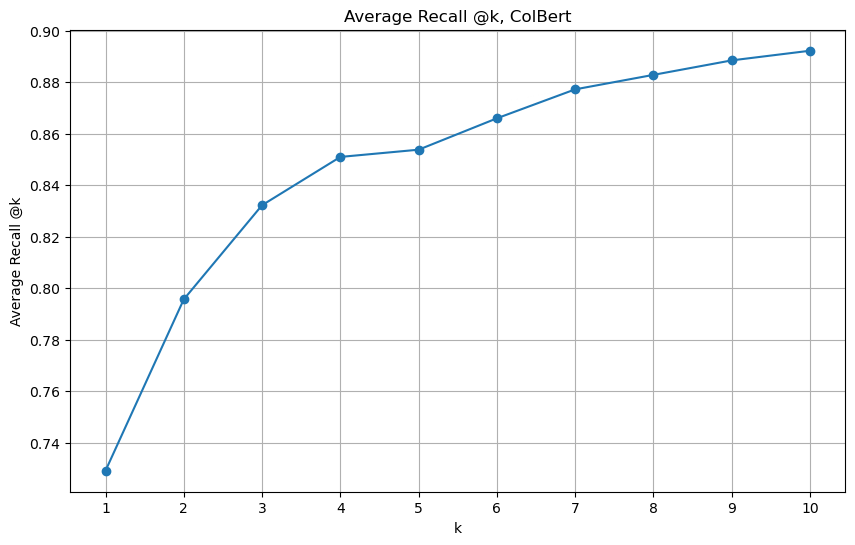

In [35]:
# Function to calculate recall @k for a single query with results pre-fetched
def calculate_recall_at_k(retrieved_docs, true_doc, k):
    recall = int(true_doc in retrieved_docs[:k])
    return recall

# Function to fetch search results once and calculate recall scores for each k
def get_recall_scores(searcher, queries, true_docs, k_range):
    recall_scores = {k: [] for k in k_range}
    for query, true_doc in tqdm.tqdm(zip(queries, true_docs), total=len(queries), desc="Calculating recall scores"):
        results = searcher.search(query, k=max(k_range))
        retrieved_docs = [searcher.collection[pid] for pid, _, _ in zip(*results)]
        for k in k_range:
            recall = calculate_recall_at_k(retrieved_docs, true_doc, k)
            recall_scores[k].append(recall)
    # Consolidate recall scores by calculating the average for each k
    average_recall_scores = {k: sum(recalls)/len(recalls) for k, recalls in recall_scores.items()}
    return average_recall_scores

# Function to plot average recall @k
def plot_average_recall_k(average_recall_scores):
    k_values = list(average_recall_scores.keys())
    recall_values = list(average_recall_scores.values())

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, recall_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('Average Recall @k')
    plt.title('Average Recall @k, ColBert')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

# Main execution
k_range = range(1, 11)

# Calculate and consolidate recall scores
average_recall_score_colbert = get_recall_scores(searcher, queries, collection, k_range)

# Print average recall scores
print("Average Recall @k:", average_recall_score_colbert)

# Plot average recall @k
plot_average_recall_k(average_recall_score_colbert)

In [36]:
df = l2_get_evaluation_set()

# Check if MPS is supported and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base').to(device)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

document_ids, document_embeddings = [], []
for i, item in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    # Tokenize the text and move inputs to the MPS device
    inputs = context_tokenizer(item[l2_DOCUMENT], return_tensors='pt', padding=True, truncation=True).to(device)
    
    # Perform the encoding
    embeddings = context_encoder(**inputs).pooler_output
    
    # Collect the results
    document_ids.append(item.name) 
    document_embeddings.append(embeddings.detach())  

document_embeddings = torch.stack(document_embeddings).squeeze()
document_embeddings

Using device: mps


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokeniz

tensor([[ 0.0643,  0.5108, -0.3469,  ..., -0.1306,  0.1911, -0.2928],
        [ 0.4021,  0.1684, -0.0578,  ...,  0.0535,  0.0082, -0.3187],
        [ 0.0550,  0.1137, -0.0191,  ..., -0.3129,  0.1339, -0.1607],
        ...,
        [-0.1665,  0.2625,  0.1651,  ...,  0.2626,  0.2654,  0.2500],
        [-0.3085,  0.7757,  0.3021,  ...,  0.1247,  0.3592,  0.1268],
        [-0.1805,  0.9499,  0.1829,  ...,  0.2678,  0.6320, -0.0149]],
       device='mps:0')

In [37]:
from collections import defaultdict
from model_helper import two_gram_overlap

def calculate_recall_at_k(similarity_scores, true_doc_id, k):
    top_k_indices = similarity_scores.topk(k=k).indices
    return true_doc_id in top_k_indices

# Recall@K results
recall_results_dpr = defaultdict(lambda: 0)
dpr_scores = []
two_gram_overlaps = []
two_gram_top_k = 10

question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base').to(device)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    query_inputs = question_tokenizer(row[l2_QUERY], return_tensors='pt', padding=True, truncation=True).to(device)
    query_embedding = question_encoder(**query_inputs).pooler_output

    # Compute dot product similarity and rank documents
    similarity_scores = torch.matmul(query_embedding, document_embeddings.T).squeeze()
    
    # Calculate two gram overlap
    top_k_results = similarity_scores.topk(k=two_gram_top_k)
    top_k_scores = top_k_results.values.detach().cpu().numpy() 
    top_k_indices = top_k_results.indices.detach().cpu().numpy()  

    top_k_context = [df.iloc[i][l2_DOCUMENT] for i in top_k_indices]

    for i, context in enumerate(top_k_context):
        two_gram_score = two_gram_overlap(row[l2_QUERY], context)
        dpr_scores.append(top_k_scores[i])  
        two_gram_overlaps.append(two_gram_score)

    # Update Recall@K metrics
    for k in range(1, 11):
        recall_results_dpr[k] += calculate_recall_at_k(similarity_scores, row.name, k)  

# Calculate average Recall@K over the dataset
for k in recall_results_dpr:
    recall_results_dpr[k] /= len(df)

print("Recall@K for K=1 to 10:", recall_results_dpr)

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4000/4000 [02:25<00:00, 27.50it/s]

Recall@K for K=1 to 10: defaultdict(<function <lambda> at 0x323f28360>, {1: 0.42875, 2: 0.54, 3: 0.5915, 4: 0.6275, 5: 0.653, 6: 0.67375, 7: 0.6915, 8: 0.70675, 9: 0.72, 10: 0.7335})


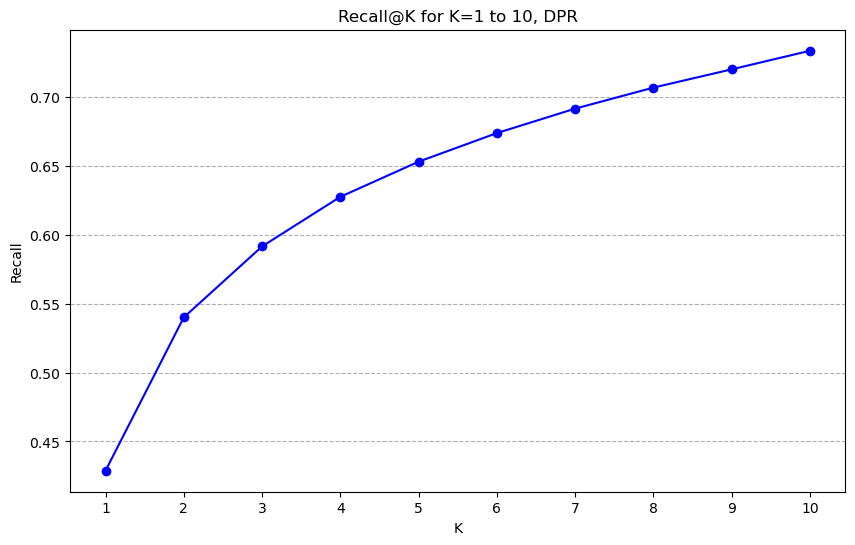

In [38]:
ks = list(recall_results_dpr.keys())
recalls = list(recall_results_dpr.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ks, recalls, marker='o', linestyle='-', color='b')
plt.title('Recall@K for K=1 to 10, DPR')
plt.xlabel('K')
plt.ylabel('Recall')
plt.xticks(ks)
plt.grid(axis='y', linestyle='--')

plt.show()

In [39]:
from tabulate import tabulate

# Data to be displayed in table
data = [
    ["BM25", recall_at_k_bm25[3], recall_at_k_bm25[5], recall_at_k_bm25[10]],
    ["ColBERT", average_recall_score_colbert[3], average_recall_score_colbert[5], average_recall_score_colbert[10]],
    ["DPR", recall_results_dpr[3], recall_results_dpr[5], recall_results_dpr[10]]
]

# Headers for the table
headers = ["Model", "Recall@3", "Recall@5", "Recall@10"]

# Create the table and choose a format - for example 'grid'
table = tabulate(data, headers=headers, tablefmt='grid')

print(table)

+---------+------------+------------+-------------+
| Model   |   Recall@3 |   Recall@5 |   Recall@10 |
+=========+============+============+=============+
| BM25    |   0.571696 |   0.58388  |    0.606373 |
+---------+------------+------------+-------------+
| ColBERT |   0.83224  |   0.853796 |    0.892221 |
+---------+------------+------------+-------------+
| DPR     |   0.5915   |   0.653    |    0.7335   |
+---------+------------+------------+-------------+
